In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import datasets
%matplotlib inline

class logistic_regression:
    
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    
    def _log_grad(self, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, self.w.T).flatten()+self.w0
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    
    def _optimize(self, X, target):
        for i in range(self.n_iterations):        
            grad_w, grad_w0 = self._log_grad(X, target)
            self.w = self.w-self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0
    
    def fit(self, X, target):
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        self._optimize(X, target)
    
    def predict_proba(self, X):  
        '''
        Рассчёт вероятности
        '''
        score=X.dot(self.w.T).flatten()+self.w0
        return 1/(1+np.exp(-score))
    
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted
   
    @staticmethod
    def confusion(predicted, actual):
        TP=np.sum(np.logical_and(predicted==1, actual==1))
        FP=np.sum(np.logical_and(predicted==1, actual==0))
        FN=np.sum(np.logical_and(predicted==0, actual==1))
        TN=np.sum(np.logical_and(predicted==0, actual==0))
        return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}
    
    @staticmethod
    def _TPR_FPR(target):
    
        bins_pos=target
        bins_neg=1-target
        num_pos, num_neg=np.sum(bins_pos), np.sum(bins_neg)
        
        #Чувствительность, доля объектов негативного класса, которых при текущем значении предела
        #правильно записали в негативный класс
        TPR=np.concatenate([[0], np.cumsum(bins_neg)/num_neg])
        
        #Ложно-позитивный уровень, доля объектов положительного класса, которых при текущем значении предела
        #ошибочно записали в негативный класс
        FPR=np.concatenate([[0], np.cumsum(bins_pos)/num_pos])
        
        precision=np.cumsum(bins_neg)/(np.cumsum(bins_neg)+np.cumsum(bins_pos))
        
        recall = TPR
        
        return TPR, FPR, precision, recall 
        
    def AUC_ROC(self, target, plotdraw=False):
        
        TPR, FPR, _, _ = self._TPR_FPR(target) 
        
        AUC_ROC = np.sum((FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1])/2)
        
        if plotdraw: 
            plt.title('ROC curve')
            plt.ylim(0, 1.05)
            plt.xlabel('FPR')
            plt.ylabel('TPR')
            plt.grid()
            plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
            plt.plot(FPR, TPR)
            
        return AUC_ROC
        
    def AUC_PR(self, target, plotdraw=False):
        
        _, _, precision, recall = self._TPR_FPR(target)
        
        AUC_PR = np.sum(precision*(recall[1:]-recall[:-1]))
        
        if plotdraw:
            plt.title('PR curve')
            plt.ylim(0, 1.05)
            plt.xlabel('recall')
            plt.ylabel('presision')
            plt.grid()
            plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
            plt.plot(recall[1:], precision)
            
        return AUC_PR

In [2]:
# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=1)

# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (70, 2)
Размер массива признаков тестовой выборки (30, 2)
Размер массива ответов для обучающей выборки (70,)
Размер массива ответов для тестовой выборки (30,)


Определите AUC_ROC и AUC_PR для модели логистической регрессии на тестовой выборке. Используйте реализацию модели в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.

In [3]:
mod=logistic_regression()
mod.fit(X_train, y_train)

proba=np.unique(mod.predict_proba(X_test))
for p in proba:
    print(f"Для порога по вероятности {format(p)} на тестовой выборке {mod.confusion(mod.predict(X_test, p), y_test)}")
   

Для порога по вероятности 0.37576183889983183 на тестовой выборке {'TP': 16, 'FP': 13, 'FN': 0, 'TN': 1}
Для порога по вероятности 0.37743531819847453 на тестовой выборке {'TP': 16, 'FP': 12, 'FN': 0, 'TN': 2}
Для порога по вероятности 0.38605073396047773 на тестовой выборке {'TP': 16, 'FP': 11, 'FN': 0, 'TN': 3}
Для порога по вероятности 0.3932982404221594 на тестовой выборке {'TP': 16, 'FP': 10, 'FN': 0, 'TN': 4}
Для порога по вероятности 0.3960311448763592 на тестовой выборке {'TP': 16, 'FP': 9, 'FN': 0, 'TN': 5}
Для порога по вероятности 0.4219700922749085 на тестовой выборке {'TP': 16, 'FP': 8, 'FN': 0, 'TN': 6}
Для порога по вероятности 0.4258110607284189 на тестовой выборке {'TP': 16, 'FP': 7, 'FN': 0, 'TN': 7}
Для порога по вероятности 0.4351868598210908 на тестовой выборке {'TP': 16, 'FP': 6, 'FN': 0, 'TN': 8}
Для порога по вероятности 0.43566683838569675 на тестовой выборке {'TP': 16, 'FP': 5, 'FN': 0, 'TN': 9}
Для порога по вероятности 0.43744861232054794 на тестовой выборке

In [4]:
porog = 0.57
predicted=mod.predict(X_test,porog)

print(f"Для порога по вероятности {porog} на тестовой выборке {mod.confusion(mod.predict(X_test), y_test)}")

Для порога по вероятности 0.57 на тестовой выборке {'TP': 15, 'FP': 0, 'FN': 1, 'TN': 14}


AUC_ROC = 0.584


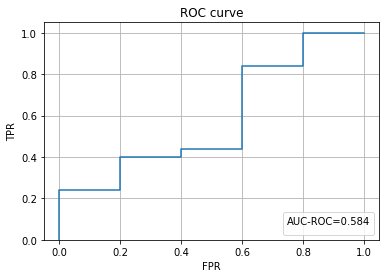

In [5]:
 print(f"AUC_ROC = {mod.AUC_ROC(predicted,True)}")

AUC_PR = 0.8905265444490361


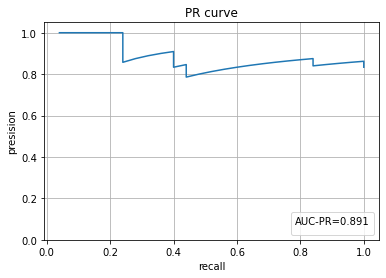

In [6]:
print(f"AUC_PR = {mod.AUC_PR(predicted,True)}")